In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd

# then import my own modules
from Featurization import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FusedEmbedding(nn.Module):

    def __init__(self, radius, T, input_feature_dim, input_bond_dim,\
            fingerprint_dim, embedding_dim, output_units_num, p_dropout=0.0):
        super(FusedEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=p_dropout)
#         self.norm = LayerNorm(fingerprint_dim)
        self.atom_fc = nn.Linear(input_feature_dim, fingerprint_dim)        
        self.neighbor_fc = nn.Linear(input_feature_dim+input_bond_dim, fingerprint_dim)
        self.atom_GRU = nn.ModuleList([nn.GRUCell(fingerprint_dim, fingerprint_dim) for r in range(radius)])

#         self.fused_align = nn.ModuleList([nn.Linear(embedding_dim+fingerprint_dim,1) for head in range(3)])
#         self.fused_attend = nn.ModuleList([nn.Linear(fingerprint_dim, fingerprint_dim) for head in range(3)])
#         self.fused_fc = nn.Linear(fingerprint_dim+embedding_dim, fingerprint_dim) 
        self.fused_GRU = nn.GRUCell(embedding_dim, fingerprint_dim)
        self.output = nn.Linear(fingerprint_dim, output_units_num) 
        self.radius = radius
        self.T = T
        self.embedding_dim = embedding_dim

    def forward(self, atom_list, bond_list, atom_degree_list, bond_degree_list, atom_mask, seq_embeddings):
        atom_mask = atom_mask.unsqueeze(2)
        batch_size,mol_length,num_atom_feat = atom_list.size()
        atom_feature = F.relu(self.atom_fc(atom_list)) * atom_mask

        bond_neighbor = [bond_list[i][bond_degree_list[i]] for i in range(batch_size)]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        atom_neighbor = [atom_list[i][atom_degree_list[i]] for i in range(batch_size)]
        atom_neighbor = torch.stack(atom_neighbor, dim=0)
        # then catenate them
        neighbor_feature = torch.cat([atom_neighbor, bond_neighbor],dim=-1)
#         print(neighbor_feature.shape, neighbor_feature[0][0])
        max_features = torch.max(neighbor_feature,dim=-2)[0]
        max_features = F.relu(self.neighbor_fc(max_features))
#         print(max_features.shape, max_features[0])
        batch_size, mol_length, fingerprint_dim = atom_feature.shape
        atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
        max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
        atom_feature_GRU = self.atom_GRU[0](max_features_reshape, atom_feature_reshape)
        atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask        

        for d in range(self.radius-1):
            neighbor_feature = [atom_feature[i][atom_degree_list[i]] for i in range(batch_size)]
            # neighbor_feature is a list of 3D tensor, so we need to stack them into a 4D tensor first
            neighbor_feature = torch.stack(neighbor_feature, dim=0)
            # then max-pooling 
            max_features = torch.max(neighbor_feature,dim=-2)[0]

            atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
            max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
            atom_feature_GRU = self.atom_GRU[d+1](max_features_reshape, atom_feature_reshape)
            atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask
        mol_feature = torch.sum(atom_feature,-2)            
        fused_feature = mol_feature
        for t in range(self.T):
            fused_feature = self.fused_GRU(seq_embeddings, fused_feature)
        fused_prediction = self.output(self.dropout(F.relu(fused_feature)))
        return fused_prediction

In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

all number:  13383
number of screen libary:  5318
2-D08
9-Aminoacridine
A-196
Acetylvanillin
Aminoacrid
Apremilast
Benorylate
Etoposide
Fenspiride
S7983
SMILES
VU
number of processed smiles:  5273


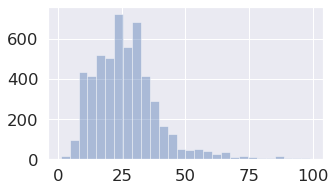

In [4]:
smilesList = []
with open('../data/screen_library.txt','rb') as f:
    for line in f:
        smilesList.append(line.split()[0].decode("utf-8"))
        
print("all number: ",len(smilesList))
smilesList = sorted(list(set(smilesList)))
print("number of screen libary: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        if len(mol.GetAtoms()) < 101:
            atom_num_dist.append(len(mol.GetAtoms()))
            remained_smiles.append(smiles)
            canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of processed smiles: ", len(remained_smiles))

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [5]:
task_name = 'Multi-Targeting'
tasks = ['activity']
sub_task1 = ['RET','MKNK1','BRAF','SRC','RPS6KB1','TTK','MAPK15','PDPK1','PAK3']
sub_task2 = ['AURKA','PAK1','FGFR1','STK11','PAK3','MAP3K7','PIK3CA']

kinase_seq_embedding = pd.read_csv('../data/kinase_seq_embedding.csv')

seq_embeddings_dict = {}
for kinase in list(set(sub_task1 + sub_task2)):
    seq_embeddings_dict[kinase] = [float(x) for x in kinase_seq_embedding.loc[kinase_seq_embedding['kinase']==kinase].embedding.values[0]\
                                 .replace("[", "").replace("]", "").replace(" ", "").split(',')]
    
kinase_list=[]
seq_embeddings=[]
for k, v in sorted(seq_embeddings_dict.items()):
    kinase_list.append(k)
    seq_embeddings.append(v)
print(kinase_list)


['AURKA', 'BRAF', 'FGFR1', 'MAP3K7', 'MAPK15', 'MKNK1', 'PAK1', 'PAK3', 'PDPK1', 'PIK3CA', 'RET', 'RPS6KB1', 'SRC', 'STK11', 'TTK']


In [6]:
random_seed = 28
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 500
epochs = 100
p_dropout = 0.18
fingerprint_dim = 180

radius = 5
T = 3
weight_decay = 4.5 # also known as l2_regularization_lambda
learning_rate = 2.8
embedding_dim = 100
output_units_num = 3 # for classification model

In [7]:
feature_dicts = get_smiles_dicts(remained_smiles)
remained_smiles = list(feature_dicts['smiles_to_atom_mask'].keys())
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([remained_smiles[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
# print(num_atom_features,num_bond_features)
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+str(fingerprint_dim)+"_"+str(p_dropout))
# OUTPUT = open('performance/kinase_peformance_'+start_time+'.csv', 'a')

loss_function = nn.CrossEntropyLoss() # torch.Tensor(loss_weight)
model = FusedEmbedding(radius, T, num_atom_features, num_bond_features,\
            fingerprint_dim, embedding_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)


*
*.O=C[Ru]1(Cl)(C=O)(C=O)NCC(=O)O1
N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.[Na+].[Na+]
[I-].[K+]


In [8]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# for p in model.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)
params = sum([np.prod(p.size()) for p in model_parameters])
# print(params)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)
        

In [9]:
def predict(model, smilesList, seq_embeddings):
    model.eval()
    y_pred_list = []
    for smiles in smilesList:
        smiles_list = [smiles] * 15
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),torch.Tensor(seq_embeddings))

        y_pred = torch.argmax(mol_prediction, dim=-1).data.squeeze().cpu().numpy()
        
        y_pred_list.append(y_pred)
        
    return np.array(y_pred_list)

In [24]:
# evaluate model
checkpoint = torch.load('saved_models/model_5r_3T_68.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

y_pred_list = predict(model, remained_smiles, seq_embeddings)


In [11]:
result_df = pd.DataFrame(data=y_pred_list,
             columns=kinase_list) 

In [12]:
result_df['smiles']=remained_smiles
result_df.to_csv('../data/model_5r_3T_68.csv',index=False)

In [13]:
result_df = pd.read_csv('../data/model_5r_3T_68.csv')

In [25]:
sub_task1 = ['RET','BRAF','SRC','RPS6KB1','MKNK1','TTK','MAPK15','PDPK1','PAK3']
sub1_df = result_df[sub_task1]
sub1_df.loc[(sub1_df['RET'] == 2) & (sub1_df['MKNK1'] == 0) \
            & (sub1_df['BRAF'] == 2) & (sub1_df['SRC'] == 2) & (sub1_df['RPS6KB1'] == 2)] #  

,RET,BRAF,SRC,RPS6KB1,MKNK1,TTK,MAPK15,PDPK1,PAK3
1500,2,2,2,2,0,1,0,0,0
1773,2,2,2,2,0,2,2,1,0
3015,2,2,2,2,0,2,2,2,2
3452,2,2,2,2,0,1,2,0,2
3472,2,2,2,2,0,1,2,0,2
4356,2,2,2,2,0,2,2,2,2


In [26]:
# get compound by index
with open('../data/screen_library.txt','rb') as f:
    for line in f:
        if line.split()[0].decode("utf-8") == remained_smiles[1500]:
            print('1500',line.split()[2])


1500 b'NG25.cdx'


In [27]:
sub_task2 = ['AURKA','PAK1','FGFR1','STK11','PAK3','MAP3K7','PIK3CA']
sub2_df = result_df[sub_task2]

# sub2_df.loc[((sub2_df['AURKA'] == 2) | (sub2_df['AURKA'] == 1)) \
#             & ((sub2_df['PAK1'] == 2) | (sub2_df['PAK1'] == 1)) \
#             & ((sub2_df['PAK3'] == 0) | (sub2_df['PAK3'] == 1)) \
#             & ((sub2_df['MAP3K7'] == 0) | (sub2_df['MAP3K7'] == 1))] #  

# sub2_df.loc[(sub2_df['AURKA'] == 2)\
#             & ((sub2_df['PAK1'] == 2) | (sub2_df['PAK1'] == 1)) \
#             & ((sub2_df['PAK3'] == 0)) \
#             & ((sub2_df['MAP3K7'] == 0))] 

sub2_df.loc[((sub2_df['AURKA'] == 2) | (sub2_df['AURKA'] == 1))\
            & ((sub2_df['PAK1'] == 2) | (sub2_df['PAK1'] == 1)) \
            & ((sub2_df['FGFR1'] == 2) | (sub2_df['FGFR1'] == 1)) \
            & ((sub2_df['PAK3'] == 0)) \
            & ((sub2_df['MAP3K7'] == 0))] #  


,AURKA,PAK1,FGFR1,STK11,PAK3,MAP3K7,PIK3CA
891,1,1,1,0,0,0,0
904,1,1,1,0,0,0,1
2499,1,1,2,0,0,0,0
3317,1,1,2,0,0,0,1
5044,1,1,1,0,0,0,0


In [28]:
with open('../data/screen_library.txt','rb') as f:
    for line in f:
        if line.split()[0].decode("utf-8") == remained_smiles[2499]:
            print('2499',line.split()[2])
        elif line.split()[0].decode("utf-8") == remained_smiles[3317]:
            print('3317',line.split()[2])        

3317 b'PHA-665752'
2499 b'HG-9-91-01'
